In [1]:
from scprint import scPrint
from scprint.tasks import GNInfer

from bengrn import BenGRN
import scanpy as sc

from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
import numpy as np
import joblib
from huggingface_hub import hf_hub_download

from scdataloader import Preprocessor
%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium') 

→ connected lamindb: jkobject/scprint2


In [2]:
model_checkpoint_file = hf_hub_download(
    repo_id="jkobject/scPRINT", filename="v2-medium.ckpt"
)

if torch.cuda.is_available():
    print("CUDA is available, using GPU", flush=True)
    precision = "16"
    transformer = "flash"
else:
    print("CUDA is not available, using CPU", flush=True)
    precision = "32"
    transformer = "normal"

m = torch.load(model_checkpoint_file, map_location=torch.device("cpu"))
if "label_counts" in m["hyper_parameters"]:
    model = scPrint.load_from_checkpoint(
        model_checkpoint_file,
        transformer=transformer,  # Don't use this for GPUs with flashattention
        precpt_gene_emb=None,
        classes=m["hyper_parameters"]["label_counts"],
    )
else:
    model = scPrint.load_from_checkpoint(
        model_checkpoint_file,
        transformer=transformer,  # Don't use this for GPUs with flashattention
        precpt_gene_emb=None,
    )
del m

CUDA is available, using GPU
FYI: scPrint is not attached to a `Trainer`.


raw counts - pas normalisé, ni log transformed

15 cell types sous "celltype",  avec 100 cells ou moins par cell type

14  batches sous "rep". Je me disais  pas que ca valait pas le coup de traiter chaque batch séparément car ça en fait beaucoup pour la taille du dataset, mais point très ouvert si tu pense que ça vaut le coup 
 
network en sortie:
Si possible au moins 15k genes conservés, je suis plus intéressé par la qualité et la densité que la différence entre les cell types.

In [3]:
adata = sc.read_h5ad('../data/temp/rna_pbs_immune_dictionary.h5ad')
adata.obs['organism_ontology_term_id'] = 'NCBITaxon:10090'
adata.var.index = adata.var.index.astype(str).str.capitalize()

In [4]:
preprocessor = Preprocessor(
    min_valid_genes_id=min(0.9 * adata.n_vars, 10000),  # 90% of features up to 10,000
    # Turn off cell filtering to return results for all cells
    filter_cell_by_counts=300,
    min_nnz_genes=300,
    do_postp=False,
    # Skip ontology checks
    skip_validate=True,
    is_symbol=True,
)
adata = preprocessor(adata)
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 1296 renamining
filtered out 0 cells, 1296 renamining
No ENS genes found, assuming gene symbols...
Removed 0 genes.
startin QC
Seeing 92 outliers (7.10% of total dataset):
done
AnnData object with n_obs × n_vars = 1296 × 57186
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep', 'organism_ontology_term_id', 'nnz', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_id

AnnData object with n_obs × n_vars = 1296 × 57186
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep', 'organism_ontology_term_id', 'nnz', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'isTF'
    uns: 'unseen_genes'

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


avg link count: 70879561, sparsity: 1.0
base enrichment
Top central genes: []


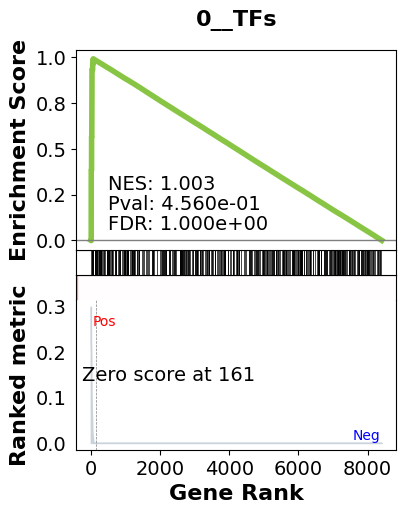

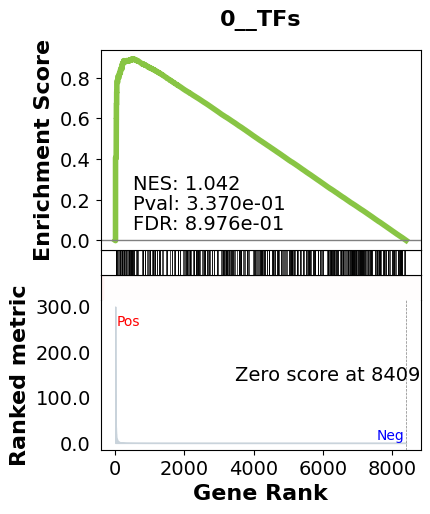

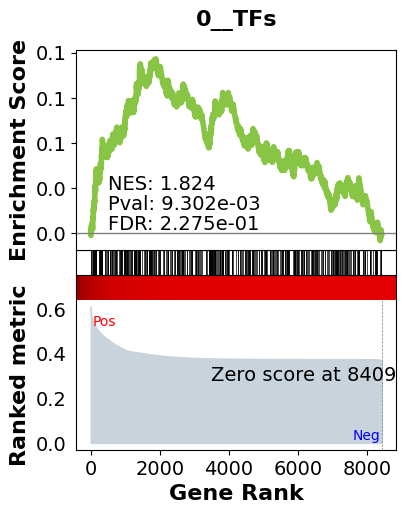

_________________________________________
TF specific enrichment
found some significant results for  3.8461538461538463 % TFs

_________________________________________
loading GT,  omnipath
intersection of 5743 genes
intersection pct: 0.6828775267538645
precision:  0.0015389886783565205 
recall:  1.0 
random precision: 0.0015392567014631657


 98%|█████████▊| 126/128 [00:07<00:00, 17.02it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:07<00:00, 17.61it/s]


Average Precision (AP):  0.0016338343249380574
Area Under Precision-Recall Curve (AUPRC):  0.0016335895843609006
EPR: 1.718855851681146


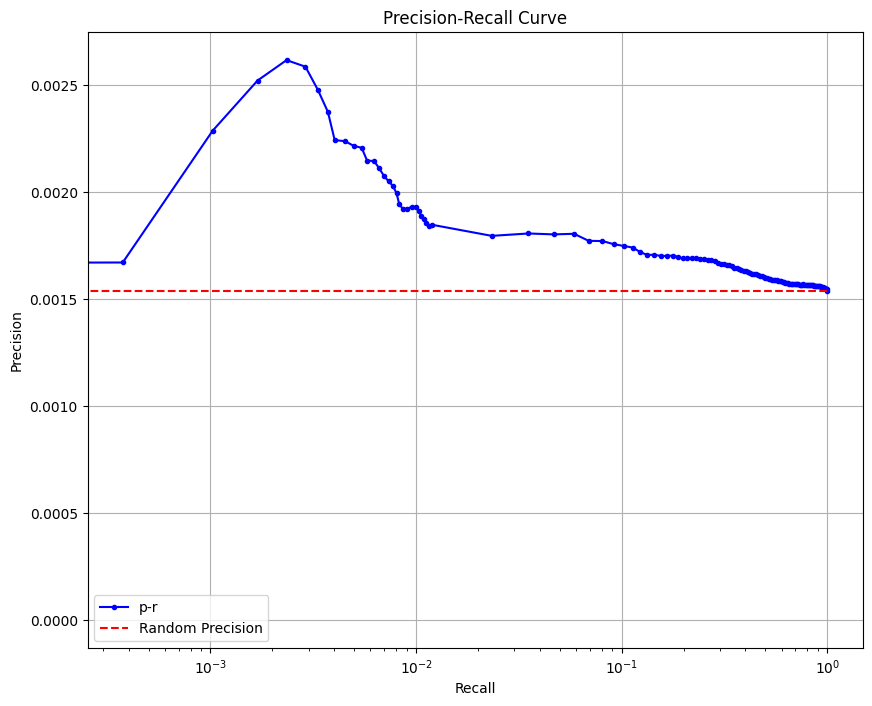

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


avg link count: 90136036, sparsity: 1.0
base enrichment
Top central genes: []


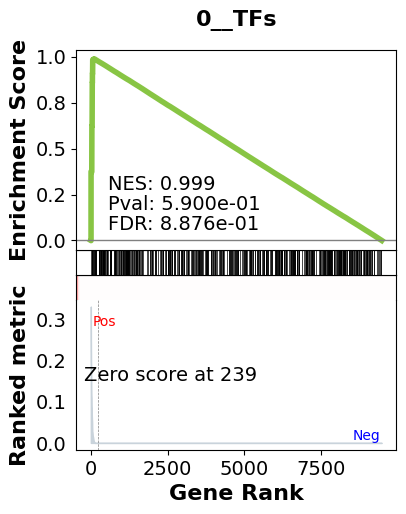

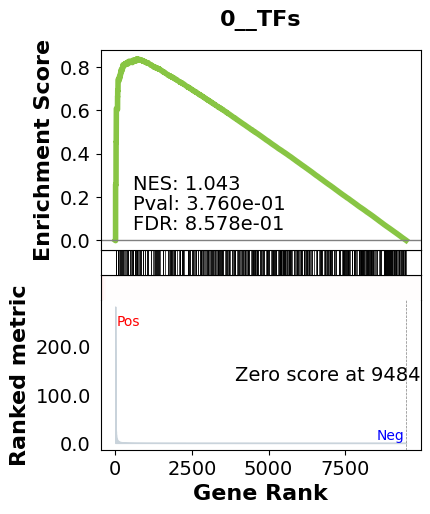

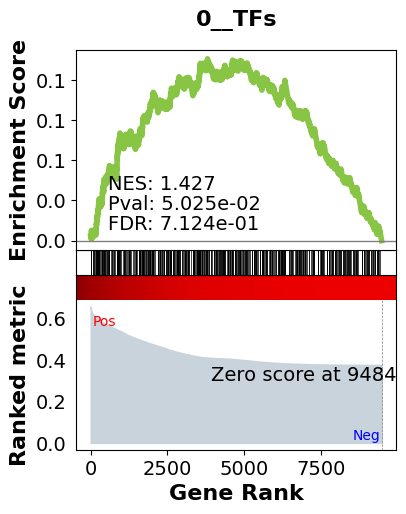

_________________________________________
TF specific enrichment
found some significant results for  6.521739130434782 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6406 genes
intersection pct: 0.6753821823932525
precision:  0.0015362295475216461 
recall:  1.0 
random precision: 0.0015364693960068173


 98%|█████████▊| 126/128 [00:09<00:00, 13.58it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:09<00:00, 13.53it/s]


Average Precision (AP):  0.001673050033120966
Area Under Precision-Recall Curve (AUPRC):  0.0016725984686652734
EPR: 1.8632343450129045


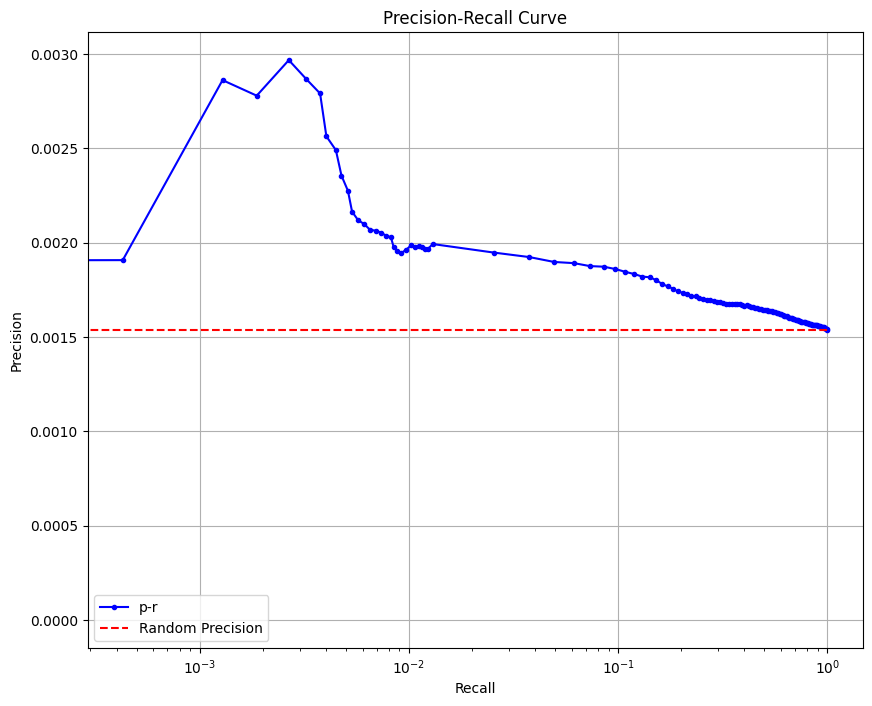

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


avg link count: 96138025, sparsity: 1.0
base enrichment
Top central genes: []


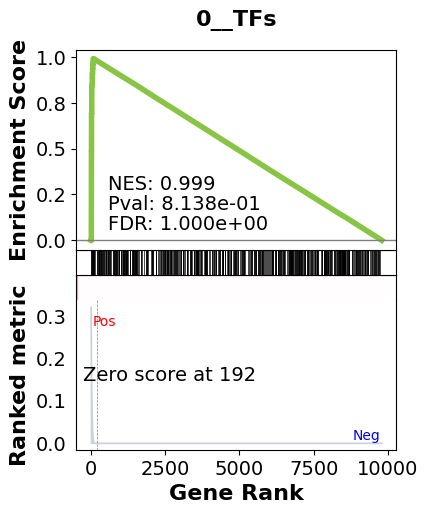

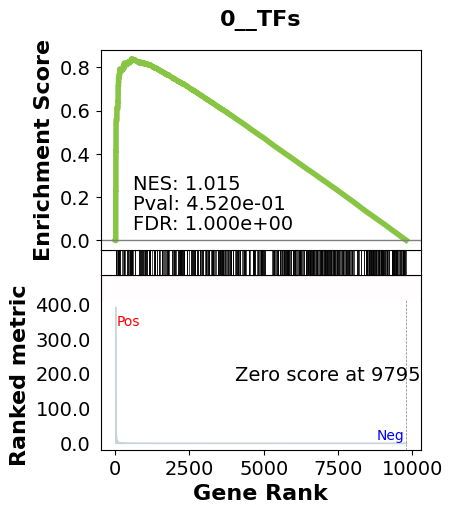

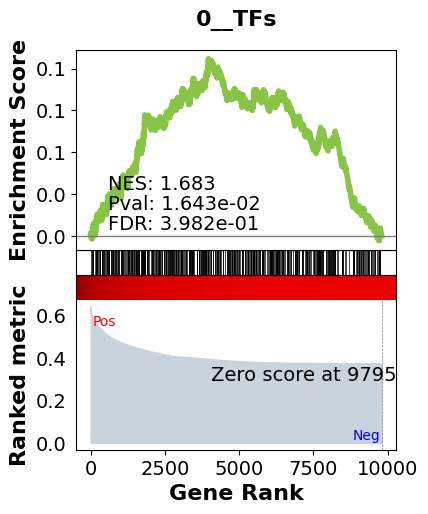

_________________________________________
TF specific enrichment
found some significant results for  11.458333333333334 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6627 genes
intersection pct: 0.6765006124948959
precision:  0.0015867157436452643 
recall:  1.0 
random precision: 0.001586955211762325


 98%|█████████▊| 126/128 [00:09<00:00, 13.28it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:09<00:00, 13.24it/s]


Average Precision (AP):  0.0016269891856396574
Area Under Precision-Recall Curve (AUPRC):  0.0016269235315358246
EPR: 1.3488654384931564


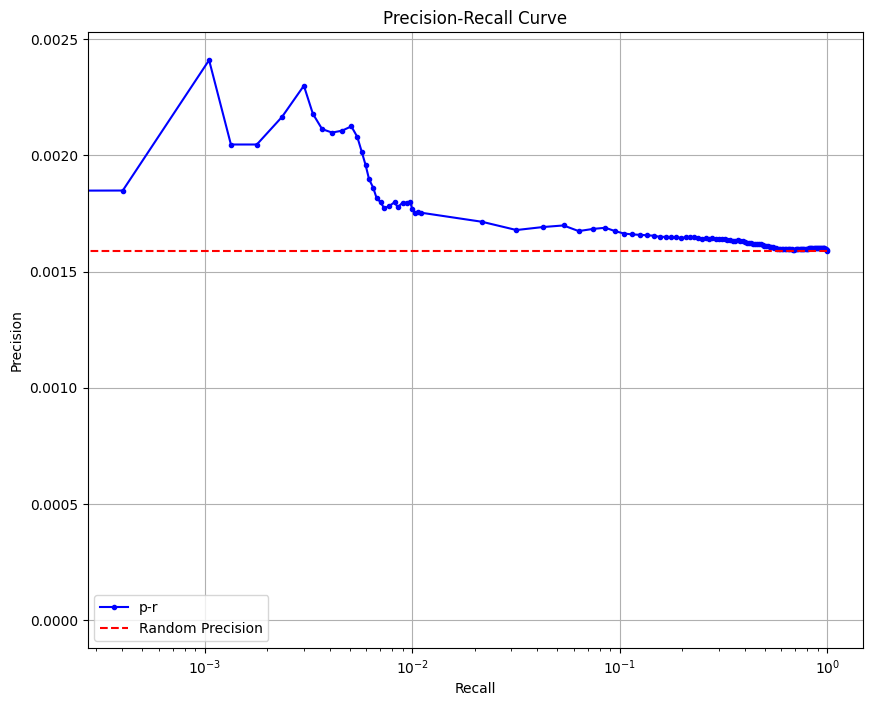

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


avg link count: 95804944, sparsity: 1.0
base enrichment
Top central genes: []


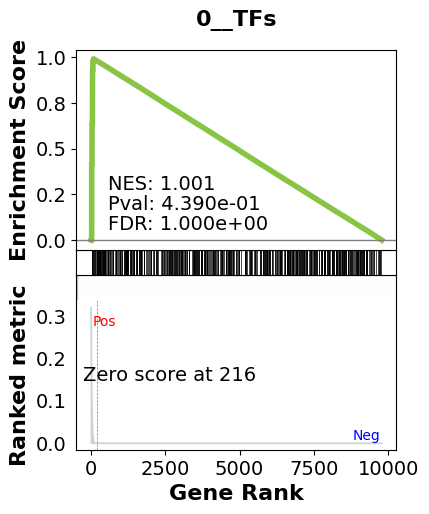

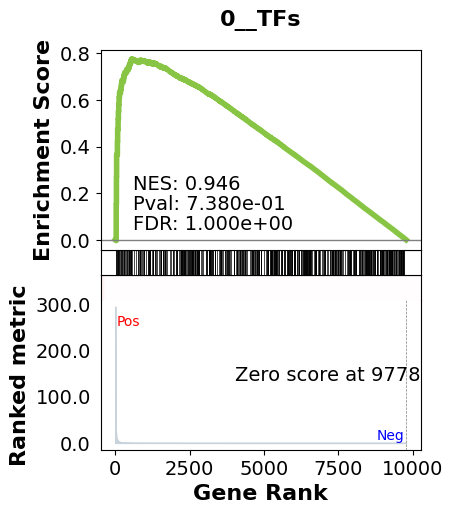

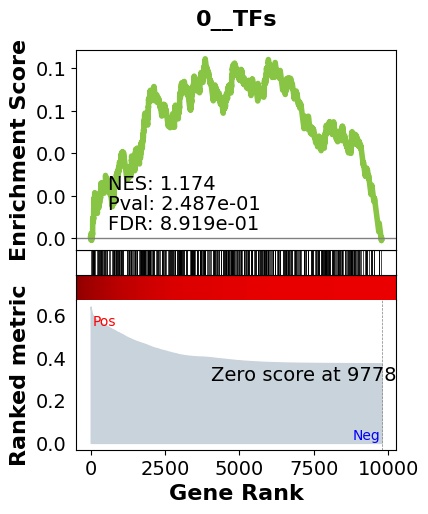

_________________________________________
TF specific enrichment
found some significant results for  11.956521739130435 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6598 genes
intersection pct: 0.6747111156559975
precision:  0.0015059630716537965 
recall:  1.0 
random precision: 0.0015061913516404046


 98%|█████████▊| 126/128 [00:09<00:00, 12.76it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:10<00:00, 12.73it/s]


Average Precision (AP):  0.0015614064436097913
Area Under Precision-Recall Curve (AUPRC):  0.0015607698976809667
EPR: 1.1448501522575716


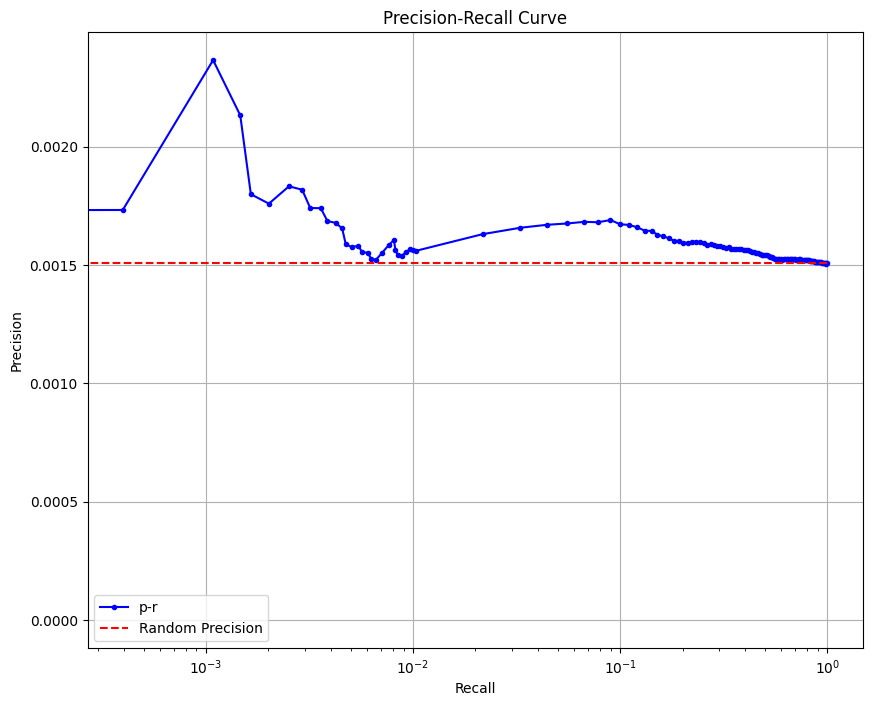

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


avg link count: 63856081, sparsity: 1.0
base enrichment
Top central genes: []


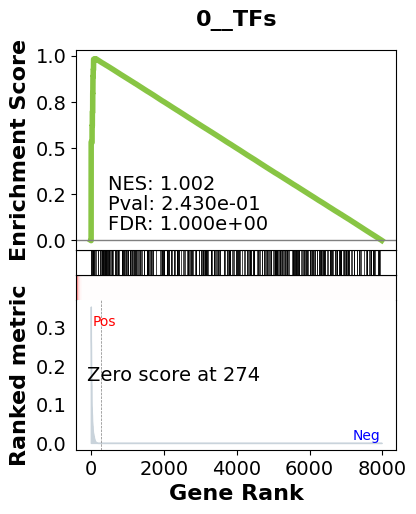

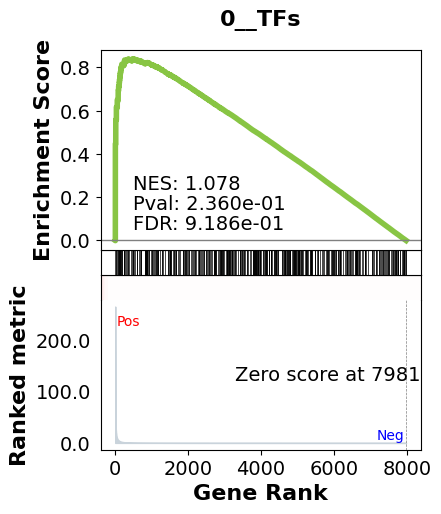

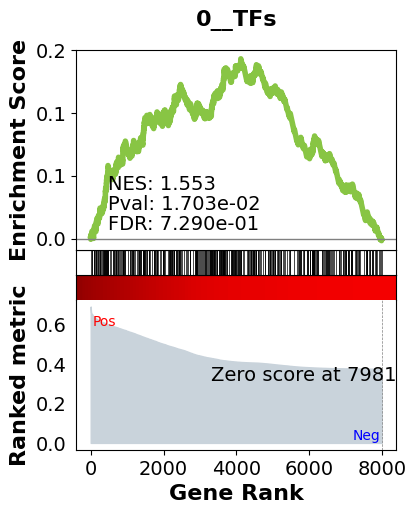

_________________________________________
TF specific enrichment
found some significant results for  9.411764705882353 % TFs

_________________________________________
loading GT,  omnipath
intersection of 5480 genes
intersection pct: 0.6865447256326735
precision:  0.0015682108796419628 
recall:  1.0 
random precision: 0.0015684971017408207


 98%|█████████▊| 126/128 [00:06<00:00, 19.47it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:06<00:00, 19.38it/s]


Average Precision (AP):  0.0016661124087835996
Area Under Precision-Recall Curve (AUPRC):  0.0016658555621197125
EPR: 1.709564838587631


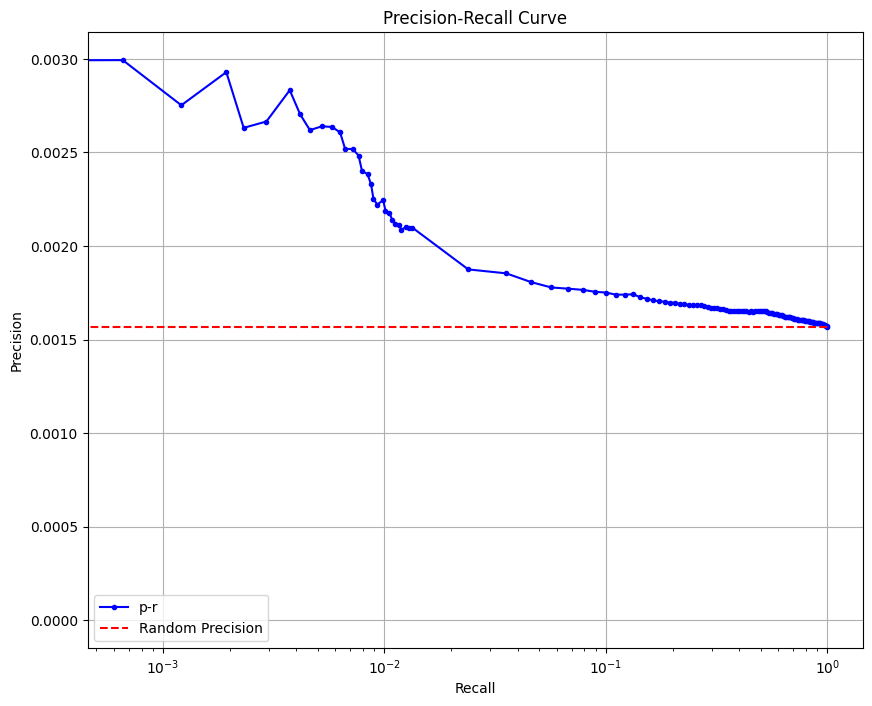

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


avg link count: 83411689, sparsity: 1.0
base enrichment
Top central genes: []


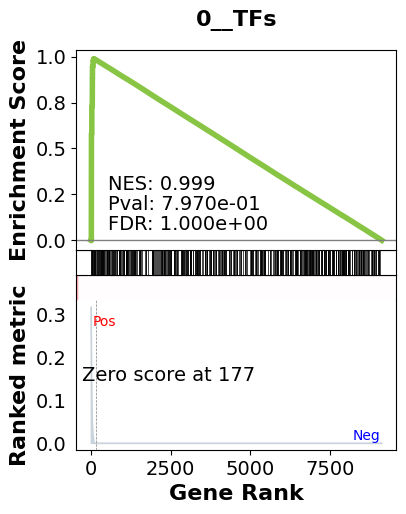

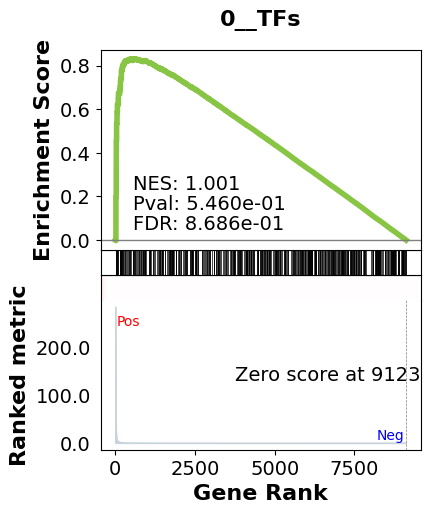

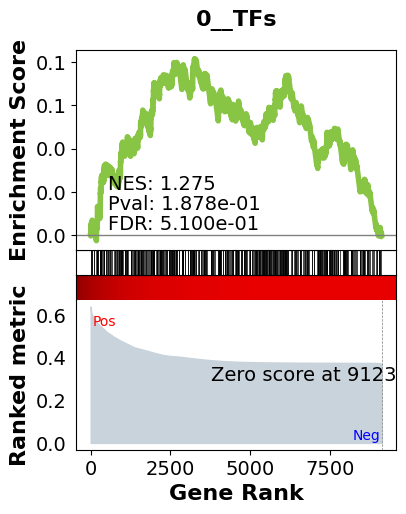

_________________________________________
TF specific enrichment
found some significant results for  10.638297872340425 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6173 genes
intersection pct: 0.6765672950460324
precision:  0.0015749780040791028 
recall:  1.0 
random precision: 0.0015752331852203988


 98%|█████████▊| 126/128 [00:08<00:00, 14.84it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:08<00:00, 14.80it/s]


Average Precision (AP):  0.001636805093850914
Area Under Precision-Recall Curve (AUPRC):  0.0016355391497508505
EPR: 1.2491382812577547


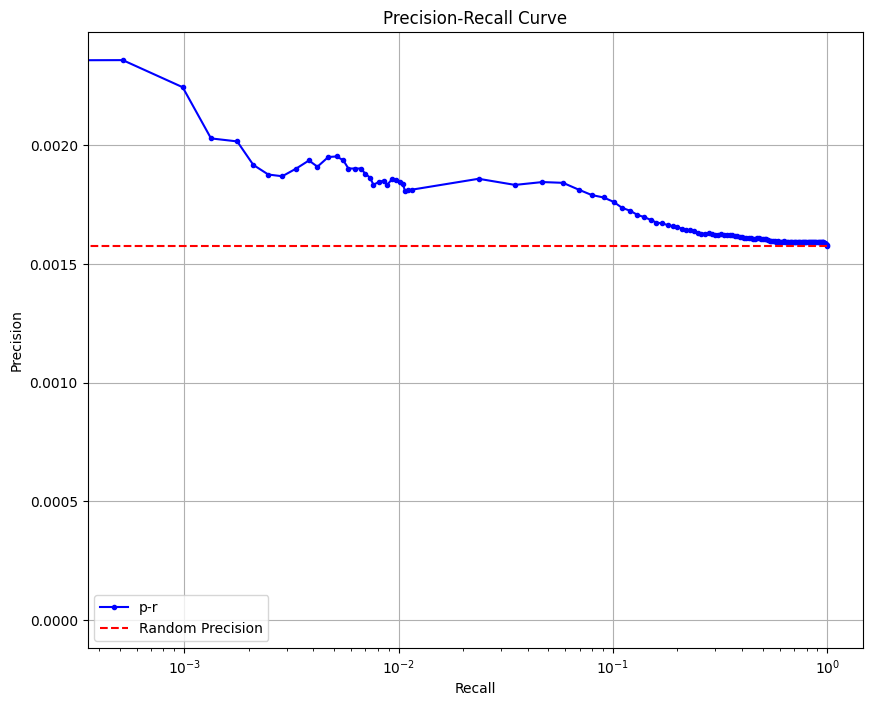

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


avg link count: 31764496, sparsity: 1.0
base enrichment
Top central genes: []


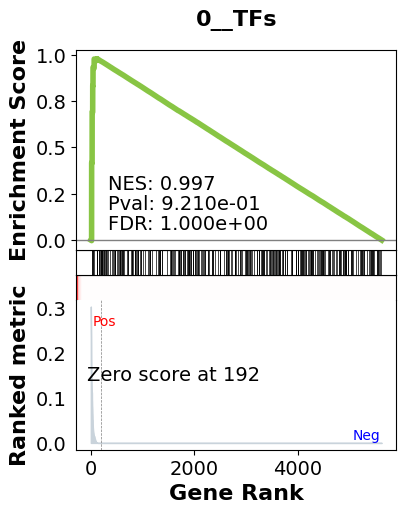

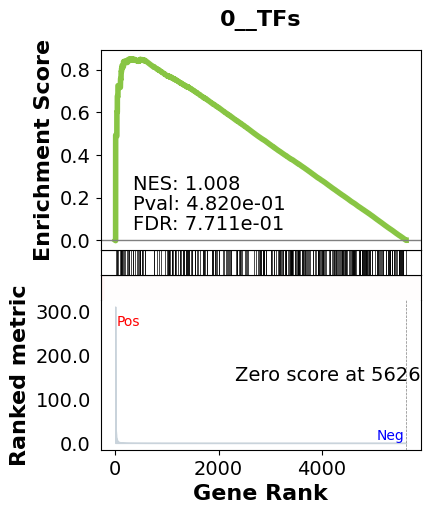

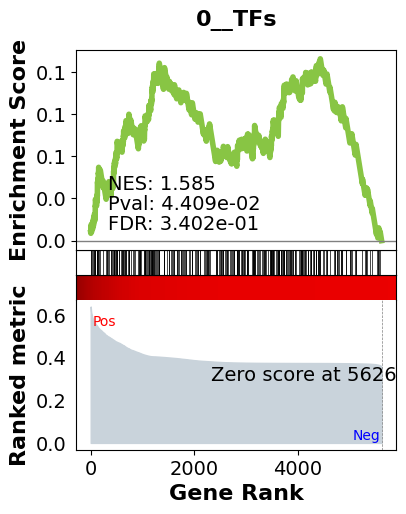

_________________________________________
TF specific enrichment
found some significant results for  9.876543209876543 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3973 genes
intersection pct: 0.7060600675315444
precision:  0.0018785878427181107 
recall:  1.0 
random precision: 0.0018790608003824406


 97%|█████████▋| 124/128 [00:03<00:00, 38.00it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:03<00:00, 37.33it/s]


Average Precision (AP):  0.0019593279450679244
Area Under Precision-Recall Curve (AUPRC):  0.001958871821196936
EPR: 1.1131833888122085


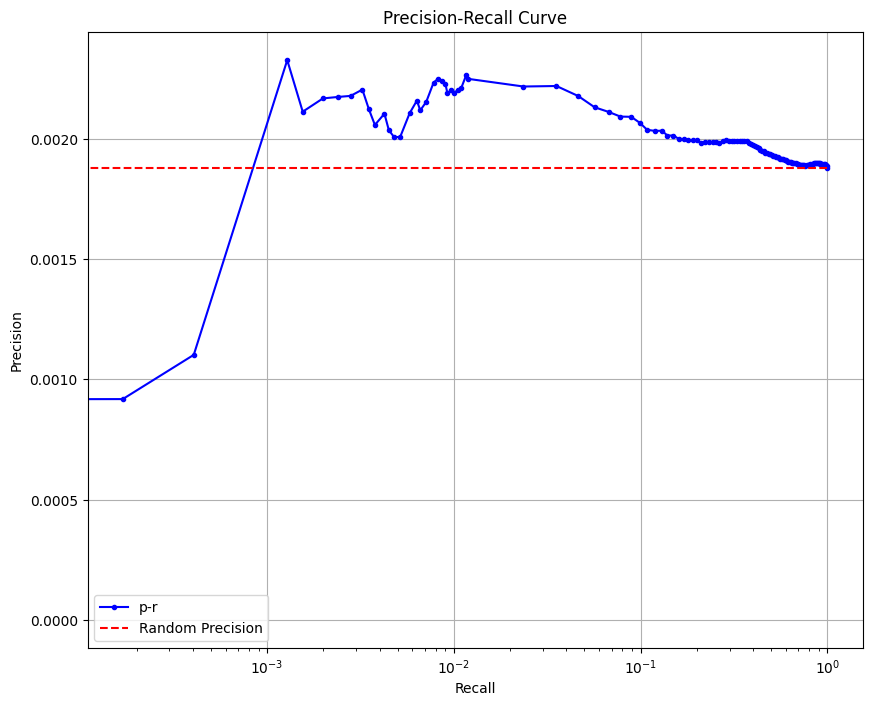

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


avg link count: 75864100, sparsity: 1.0
base enrichment
Top central genes: []


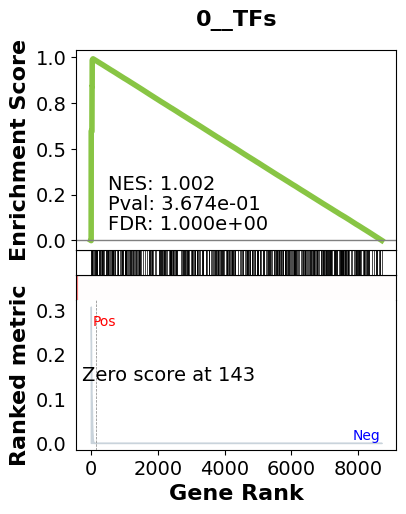

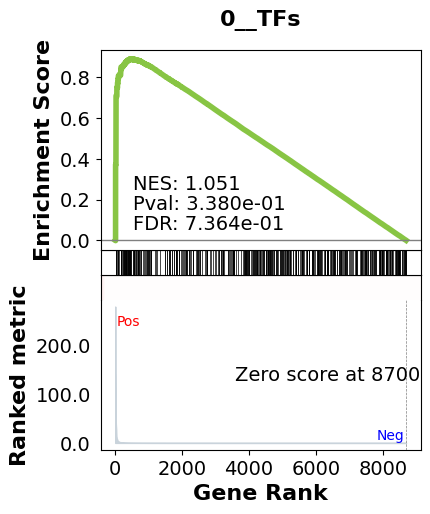

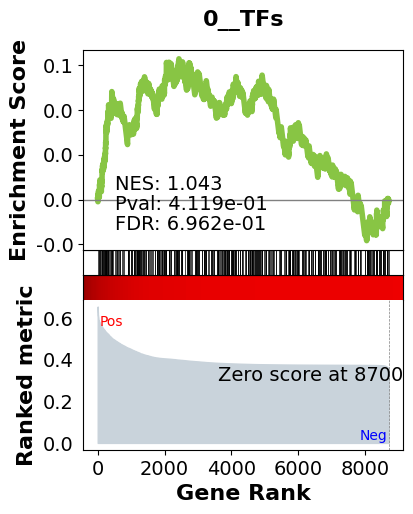

_________________________________________
TF specific enrichment
found some significant results for  9.195402298850574 % TFs

_________________________________________
loading GT,  omnipath
intersection of 5886 genes
intersection pct: 0.6764739685093667
precision:  0.001533208432178777 
recall:  1.0 
random precision: 0.0015334689603745592


 98%|█████████▊| 126/128 [00:07<00:00, 16.12it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:07<00:00, 16.07it/s]


Average Precision (AP):  0.0016420896844996907
Area Under Precision-Recall Curve (AUPRC):  0.0016417420414525435
EPR: 1.685445491553637


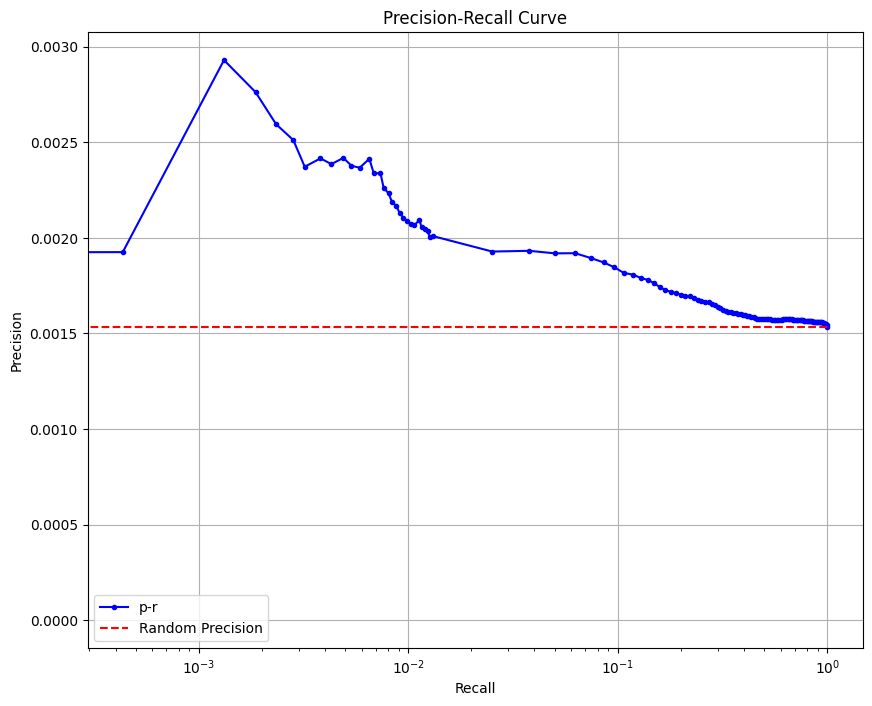

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


avg link count: 80209936, sparsity: 1.0
base enrichment
Top central genes: []


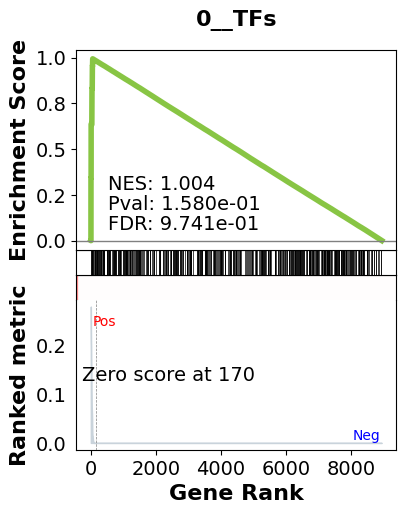

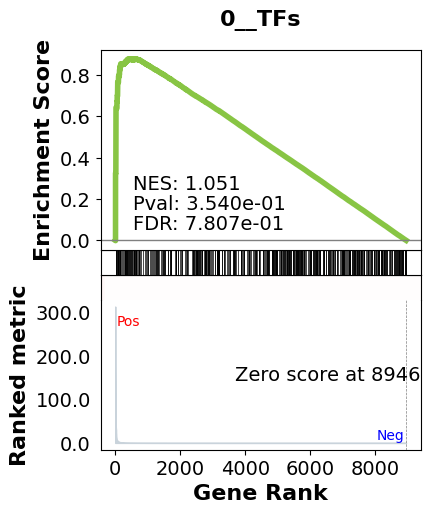

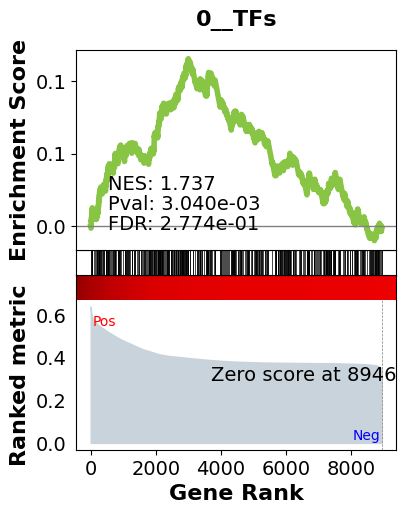

_________________________________________
TF specific enrichment
found some significant results for  7.0588235294117645 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6034 genes
intersection pct: 0.6744160053649267
precision:  0.0015476052232575783 
recall:  1.0 
random precision: 0.001547861746583164


 98%|█████████▊| 126/128 [00:08<00:00, 15.33it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:08<00:00, 15.29it/s]


Average Precision (AP):  0.0015813402787901692
Area Under Precision-Recall Curve (AUPRC):  0.0015792368486167911
EPR: 2.32553941499816


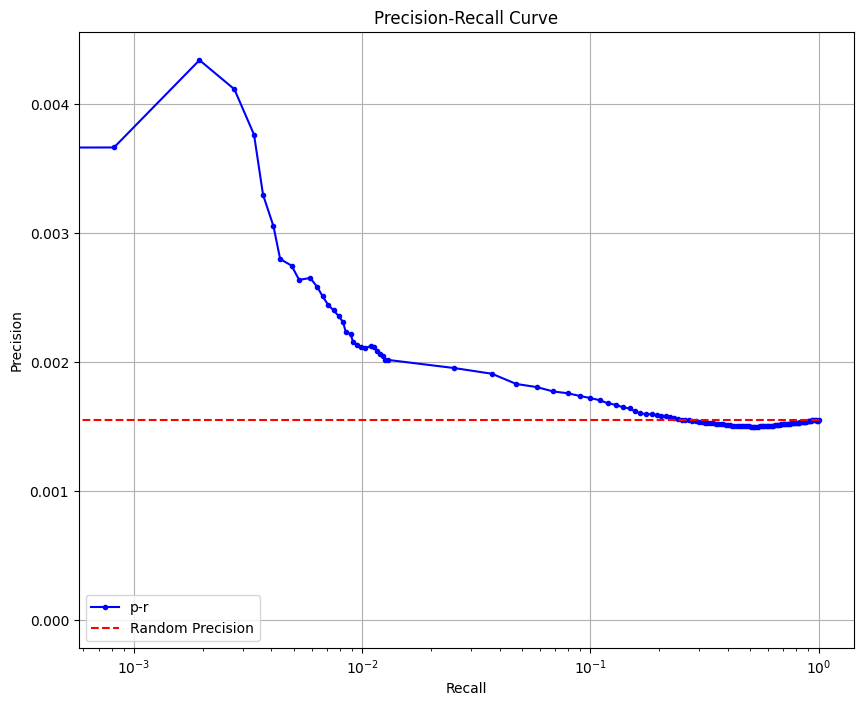

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


avg link count: 86806489, sparsity: 1.0
base enrichment
Top central genes: []


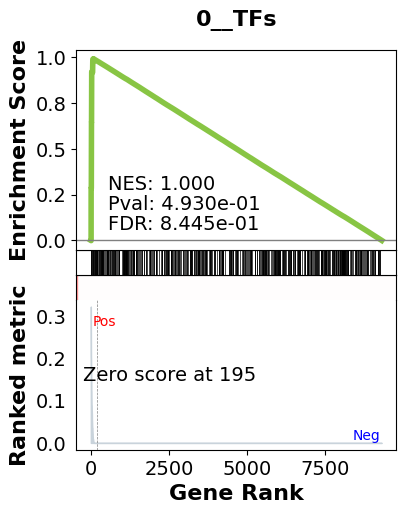

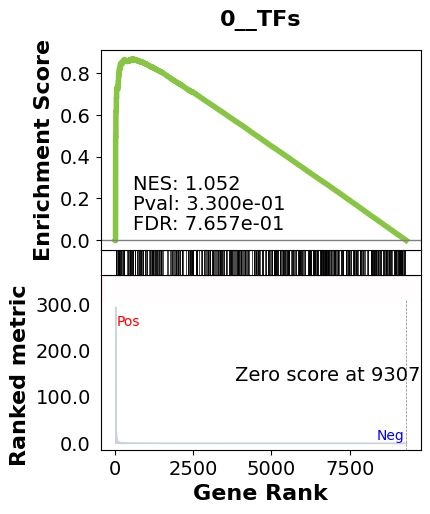

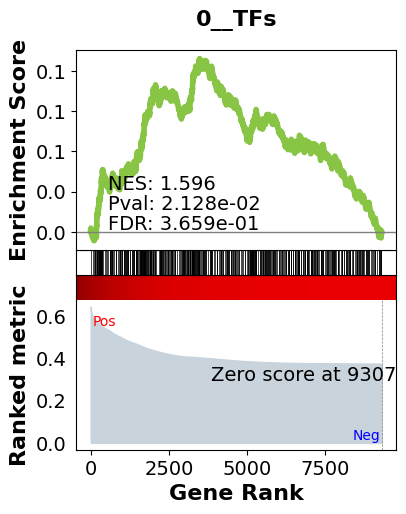

_________________________________________
TF specific enrichment
found some significant results for  8.045977011494253 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6280 genes
intersection pct: 0.6746884400515686
precision:  0.0014382175747494827 
recall:  1.0 
random precision: 0.0014384466267601133


 98%|█████████▊| 126/128 [00:08<00:00, 14.16it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:09<00:00, 14.07it/s]


Average Precision (AP):  0.0015309827262500713
Area Under Precision-Recall Curve (AUPRC):  0.0015293387026994827
EPR: 1.5220717982132461


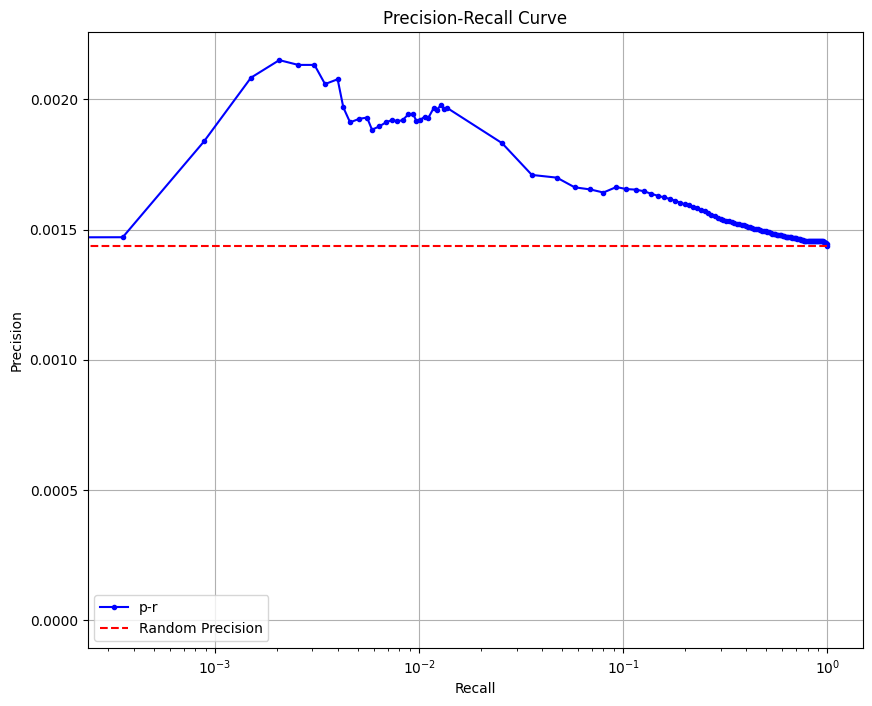

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


avg link count: 85710564, sparsity: 1.0
base enrichment
Top central genes: []


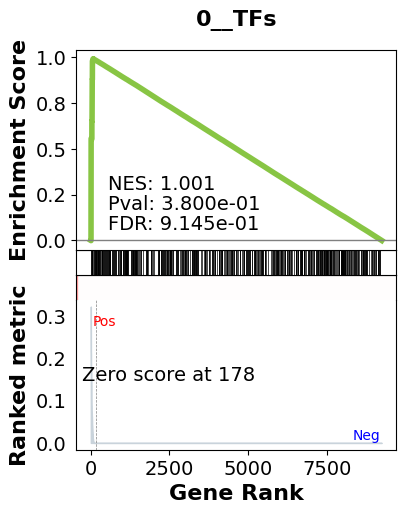

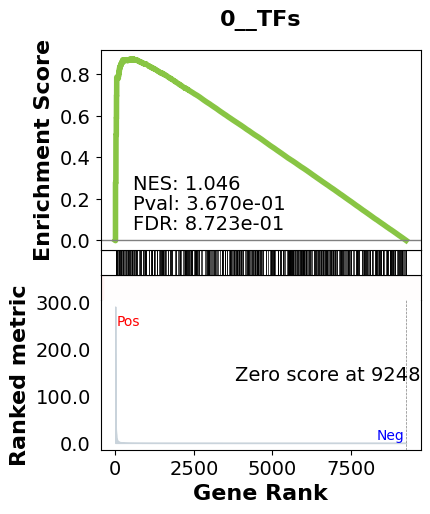

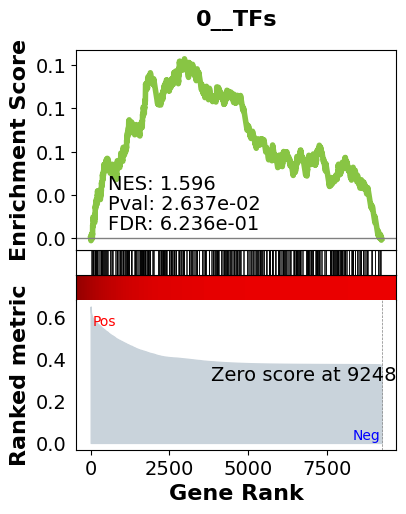

_________________________________________
TF specific enrichment
found some significant results for  6.593406593406593 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6274 genes
intersection pct: 0.6783436047140231
precision:  0.0015196729036114963 
recall:  1.0 
random precision: 0.0015199151597733982


 98%|█████████▊| 126/128 [00:08<00:00, 14.12it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:09<00:00, 14.06it/s]


Average Precision (AP):  0.0015864093376720147
Area Under Precision-Recall Curve (AUPRC):  0.0015861490475894441
EPR: 1.686307946029903


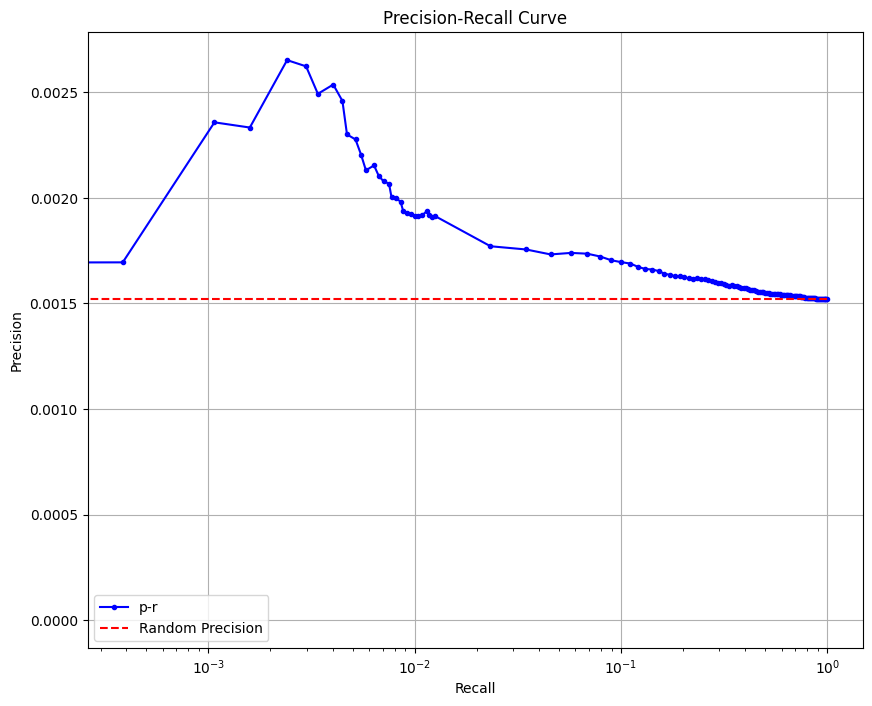

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


avg link count: 102030201, sparsity: 1.0
base enrichment
too many genes for central computation


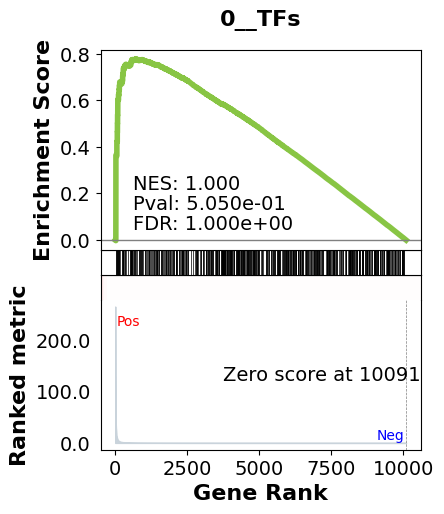

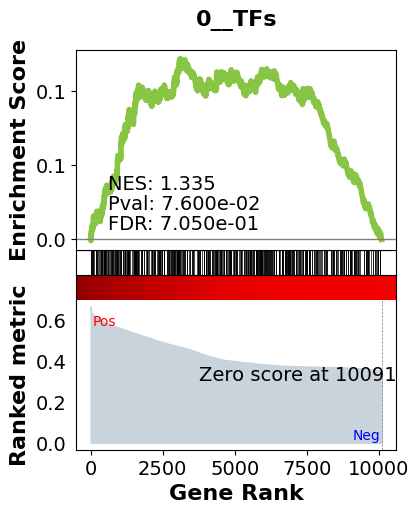

_________________________________________
TF specific enrichment
found some significant results for  10.227272727272727 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6754 genes
intersection pct: 0.6692429647245343
precision:  0.001409270273950777 
recall:  1.0 
random precision: 0.001409478961981867


 98%|█████████▊| 126/128 [00:10<00:00, 12.39it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:10<00:00, 12.34it/s]


Average Precision (AP):  0.001547751822336003
Area Under Precision-Recall Curve (AUPRC):  0.0015468933455100317
EPR: 1.7918727703985635


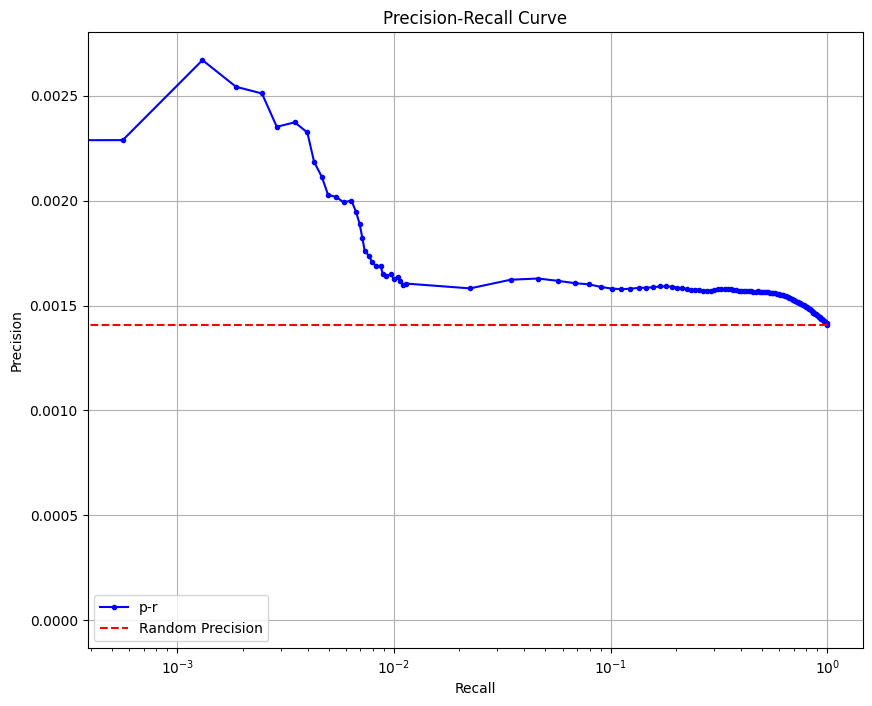

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


avg link count: 105021504, sparsity: 1.0
base enrichment
too many genes for central computation


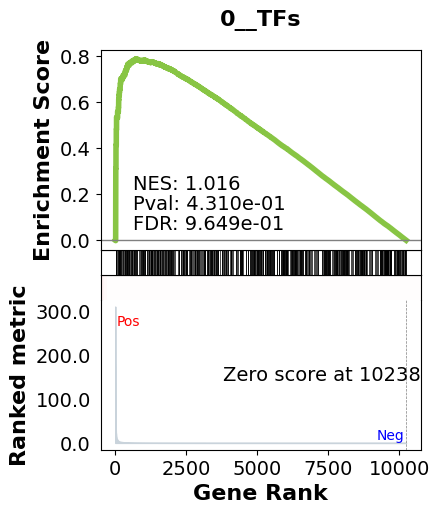

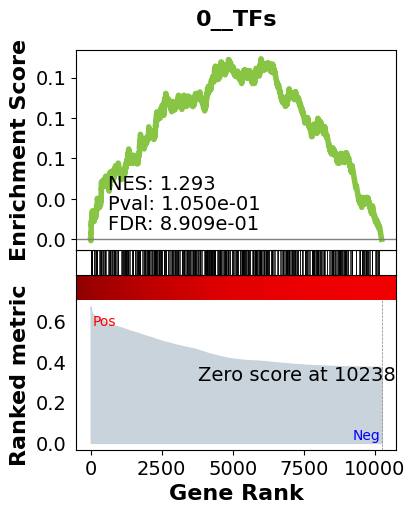

_________________________________________
TF specific enrichment
found some significant results for  10.416666666666666 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6866 genes
intersection pct: 0.6705732981736497
precision:  0.0014279636593780708 
recall:  1.0 
random precision: 0.0014281716657377763


 98%|█████████▊| 126/128 [00:10<00:00, 11.84it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:10<00:00, 11.75it/s]


Average Precision (AP):  0.001530817414605797
Area Under Precision-Recall Curve (AUPRC):  0.0015302800423668207
EPR: 1.7826228525559968


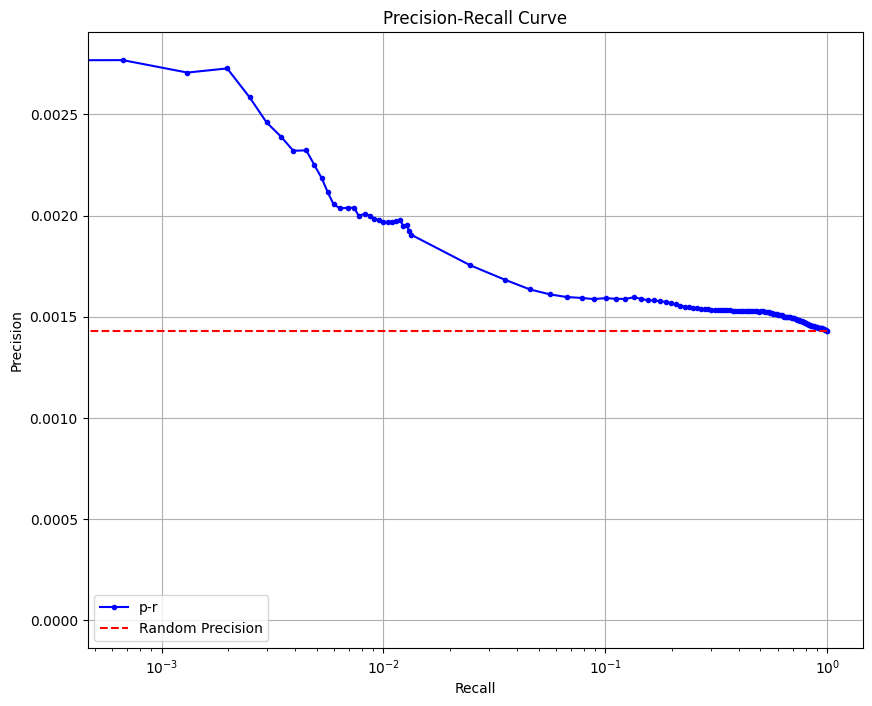

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


avg link count: 104407524, sparsity: 1.0
base enrichment
too many genes for central computation


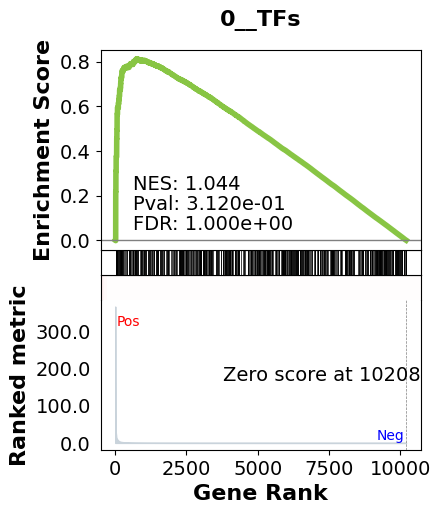

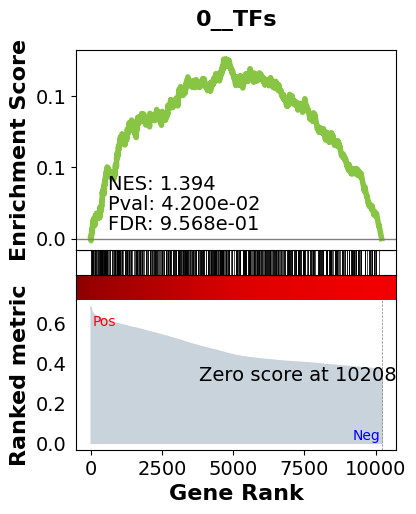

_________________________________________
TF specific enrichment
found some significant results for  16.304347826086957 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6852 genes
intersection pct: 0.6711724948574787
precision:  0.0014339965423571474 
recall:  1.0 
random precision: 0.0014342058543615783


 98%|█████████▊| 126/128 [00:10<00:00, 11.78it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:10<00:00, 11.78it/s]


Average Precision (AP):  0.0015178661570065383
Area Under Precision-Recall Curve (AUPRC):  0.0015176113818691872
EPR: 1.3476636422927912


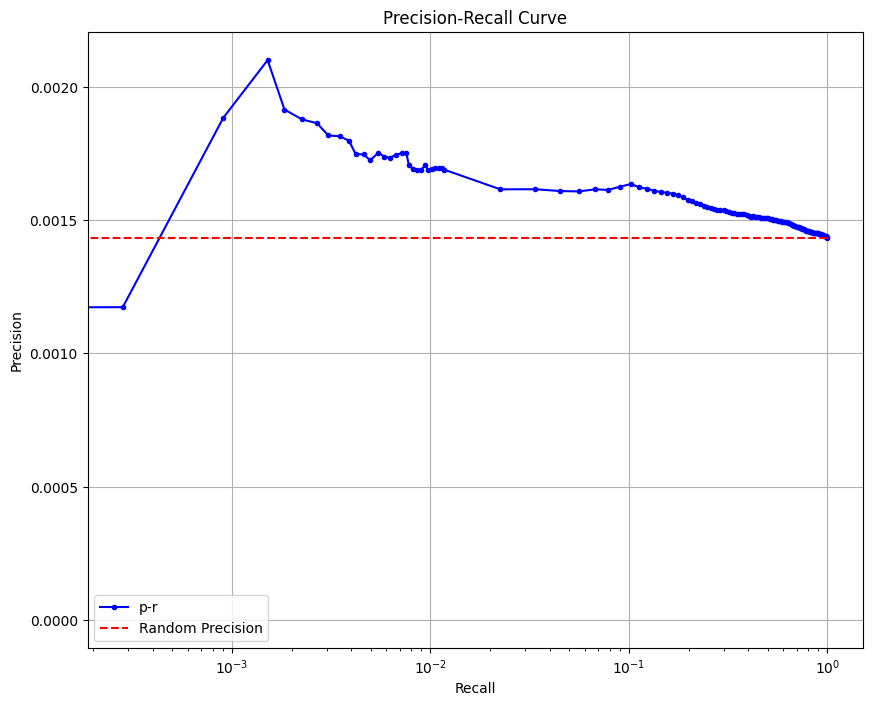

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


avg link count: 92102409, sparsity: 1.0
base enrichment
Top central genes: []


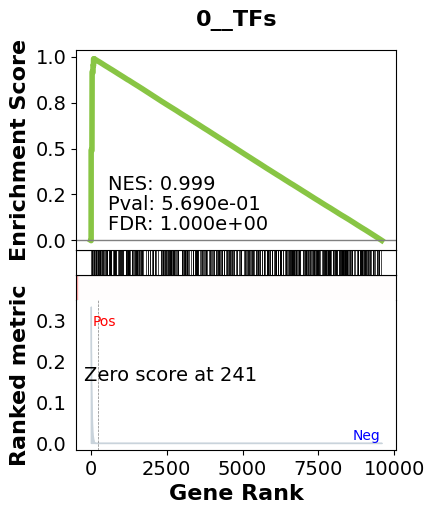

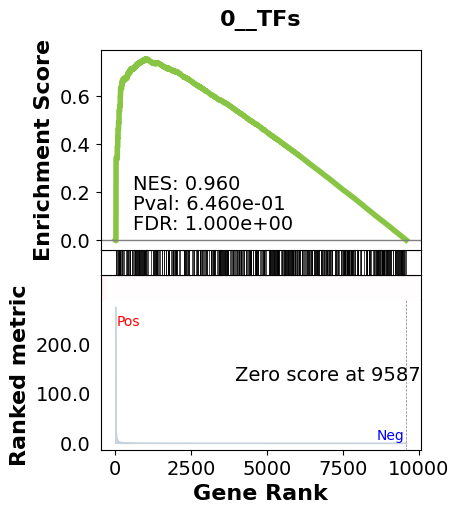

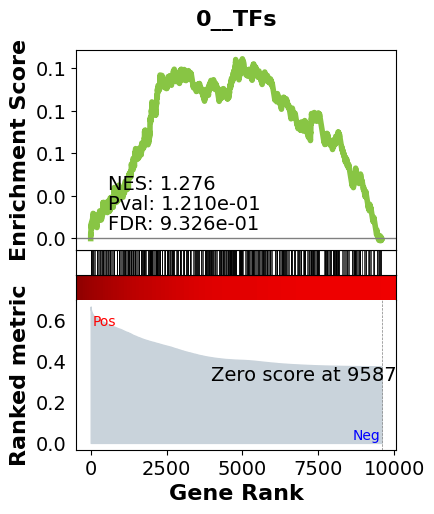

_________________________________________
TF specific enrichment
found some significant results for  6.382978723404255 % TFs

_________________________________________
loading GT,  omnipath
intersection of 6457 genes
intersection pct: 0.6734459741343346
precision:  0.0014546859102864379 
recall:  1.0 
random precision: 0.0014549112333828267


 98%|█████████▊| 126/128 [00:09<00:00, 13.23it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  # Calculate precision and recall for each threshold
100%|██████████| 128/128 [00:09<00:00, 13.38it/s]


Average Precision (AP):  0.001522372090618591
Area Under Precision-Recall Curve (AUPRC):  0.001522007018235353
EPR: 1.634917553445575


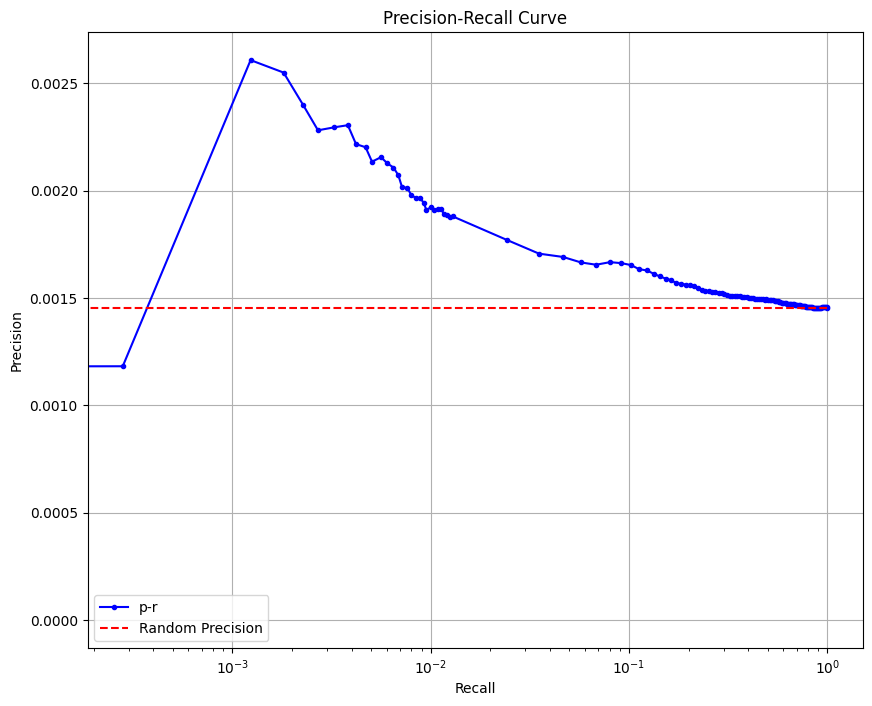

In [20]:
metrics = {}
clf_omni = None
shapes = []
for celltype in adata.obs['celltype'].unique():
    grn_inferer = GNInfer(
                        how="random expr",
                        preprocess="softmax",
                        head_agg='mean',
                        filtration="none",
                        forward_mode="none",
                        num_genes=3000,
                        max_cells=5000,
                        doplot=False,
                        batch_size=32,
                        cell_type_col="celltype",
                        layer=list(range(model.nlayers))[:]
                        )
    grn = grn_inferer(model, adata, cell_type=celltype)
    grn.var['symbol'] = grn.var['symbol'].str.upper()
    grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
    metrics[celltype+'_scprint_full'] = BenGRN(grn).scprint_benchmark()
    grn.write_h5ad(f'../data/temp/grn_{celltype}_scprint_f.h5ad')